In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    {"figure.figsize": (6, 4)},
    style='ticks',
    color_codes=True,
    font_scale=0.8
)

import numpy as np
import pandas as pd

import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, PredictionErrorDisplay
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.datasets import make_regression

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import (
    OneHotEncoder,
    TargetEncoder,
    MinMaxScaler,
    StandardScaler,
    PolynomialFeatures
)
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

import shap
shap.initjs()

In [ ]:


# Load dataset
data = pd.read_csv("/content/UK-HPI-full-file-2025-01.csv")  # replace with actual file if CSV
data["Date"] = pd.to_datetime(data["Date"])

In [ ]:
# 1. check % of nulls
df = data.copy()

null_pct = df.isna().mean() * 100

# 2. drop columns with too many nulls (>70%)
drop_cols = null_pct[null_pct > 70].index.tolist()

# Always drop 'IndexSA' and 'AveragePriceSA' (too sparse)
drop_cols += ['IndexSA', 'AveragePriceSA']

df = df.drop(columns=list(set(drop_cols)))

print("Dropped columns:", drop_cols)


df = df.drop(columns=['AreaCode'])

Dropped columns: ['IndexSA', 'AveragePriceSA', 'IndexSA', 'AveragePriceSA']


In [ ]:
# 1. Drop high-null columns
high_null_cols = [
    'CashPrice','CashIndex','Cash1m%Change','Cash12m%Change','CashSalesVolume',
    'MortgagePrice','MortgageIndex','Mortgage1m%Change','Mortgage12m%Change','MortgageSalesVolume',
    'FTBPrice','FTBIndex','FTB1m%Change','FTB12m%Change',
    'FOOPrice','FOOIndex','FOO1m%Change','FOO12m%Change'
]
df = df.drop(columns=high_null_cols, errors='ignore')

print("Dropped:", high_null_cols)

# 2. Interpolate numeric features (time-based fill)
num_cols = df.select_dtypes(include=['float64','int64']).columns
df[num_cols] = df[num_cols].interpolate(method='linear')

# 3. If still missing, backfill/forward fill
df[num_cols] = df[num_cols].fillna(method='bfill').fillna(method='ffill')

Dropped: ['CashPrice', 'CashIndex', 'Cash1m%Change', 'Cash12m%Change', 'CashSalesVolume', 'MortgagePrice', 'MortgageIndex', 'Mortgage1m%Change', 'Mortgage12m%Change', 'MortgageSalesVolume', 'FTBPrice', 'FTBIndex', 'FTB1m%Change', 'FTB12m%Change', 'FOOPrice', 'FOOIndex', 'FOO1m%Change', 'FOO12m%Change']


In [ ]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Quarter"] = df["Date"].dt.quarter

In [ ]:
numeric_cols = df.select_dtypes(exclude=['object', 'datetime64[ns]']).columns.tolist()
df[numeric_cols] = df[numeric_cols].fillna(0)
df[numeric_cols] = df[numeric_cols].astype('int64')

In [ ]:
cut = pd.Timestamp("2022-01-01")
train = df[df["Date"] < cut].copy()
test  = df[df["Date"] >= cut].copy()


In [ ]:
# Region means from TRAIN only (prevents leakage)
region_means = train.groupby("RegionName")["AveragePrice"].mean()

# Map encodings to train & test
train["RegionEncoded"] = train["RegionName"].map(region_means)

# For test rows whose region wasn't seen in train (unlikely), fill with train global mean
global_mean = train["AveragePrice"].mean()
test["RegionEncoded"] = test["RegionName"].map(region_means).fillna(global_mean)



In [ ]:
def create_features(df):
    df = df.sort_values(["RegionName","Date"]).copy()

    for lag in [1,3,6,12,24,32]:
        df[f"lag_{lag}"] = df.groupby("RegionName")["AveragePrice"].shift(lag)

    df["roll_mean_3"] = df.groupby("RegionName")["AveragePrice"].shift(1).rolling(3).mean()
    df["roll_mean_6"] = df.groupby("RegionName")["AveragePrice"].shift(1).rolling(6).mean()
    df["roll_mean_12"] = df.groupby("RegionName")["AveragePrice"].shift(1).rolling(12).mean()
    df["roll_mean_32"] = df.groupby("RegionName")["AveragePrice"].shift(1).rolling(32).mean()


    df["month"] = df["Date"].dt.month
    df["year"]  = df["Date"].dt.year
    return df

print("Rows in train before dropna:", len(train))
train = create_features(train).dropna()
print("Rows in train after dropna:", len(train))

print("Rows in test before dropna:", len(test))
test = create_features(test)
# Fill missing values in test set introduced by lags and rolling means
test = test.fillna(method='ffill').fillna(method='bfill')
print("Rows in test after fillna:", len(test))

Rows in train before dropna: 129645
Rows in train after dropna: 116685
Rows in test before dropna: 14985
Rows in test after fillna: 14985


In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from xgboost import XGBRegressor, plot_importance
# from sklearn.inspection import permutation_importance

# # Define target and features
# target_col = 'AveragePrice'
# feature_cols = ["RegionEncoded",
#                 "lag_1","lag_3","lag_6","lag_12","lag_24","lag_32",  # Corrected lags
#                 "roll_mean_3","roll_mean_6","roll_mean_12","roll_mean_32", # Corrected rolling means
#                 "month","year",
#                 ]


# X_train, y_train = train[feature_cols], train[target_col]
# X_test,  y_test  = test[feature_cols],  test[target_col]

# # ---- 2) Permutation importance slice: 2000–2015 (quarterly) ----
# mask = (train['Date'] >= '2000-01-01') & (train['Date'] <= '2015-12-31')
# X_slice = X_train.loc[mask]
# y_slice = y_train.loc[mask]

# assert len(X_slice) > 20, "2000–2015 slice too small; widen range."

# # ---- 3) Train XGBoost on the 2000–2015 slice ----
# xgb = XGBRegressor(
#     n_estimators=500,
#     learning_rate=0.05,
#     max_depth=5,
#     subsample=0.9,
#     colsample_bytree=0.9,
#     random_state=42
# )
# xgb.fit(X_slice, y_slice)

# # ---- 4) Built-in importance (Gain) – fast ----
# plt.figure(figsize=(9, 5))
# plot_importance(xgb, importance_type="gain", xlabel='Gain')
# plt.title("XGBoost Built-in Feature Importance (2000–2015 slice)")
# plt.tight_layout()
# plt.show()

# # Top-5 features by built-in gain
# booster = xgb.get_booster()
# gain_dict = booster.get_score(importance_type="gain")
# gain_series = pd.Series({f: gain_dict.get(f, 0.0) for f in X_slice.columns}).sort_values(ascending=False)
# print("Top-5 Features by Built-in Gain:")
# print(gain_series.head(5))

# # ---- 5) Permutation importance – robust ----
# perm = permutation_importance(
#     xgb, X_slice, y_slice,
#     n_repeats=5, random_state=42, n_jobs=-1
# )
# perm_df = pd.DataFrame({
#     'feature': X_slice.columns,
#     'mean_importance': perm.importances_mean,
#     'std_importance': perm.importances_std
# }).sort_values('mean_importance', ascending=False)

# plt.figure(figsize=(9, 5))
# sorted_idx = np.argsort(perm.importances_mean)
# plt.barh(X_slice.columns[sorted_idx], perm.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance (Δ score)")
# plt.title("Permutation Importance (2000–2015 slice, quarterly)")
# plt.tight_layout()
# plt.show()

# print("\nTop-5 Features by Permutation Importance:")
# print(perm_df.head(5).to_string(index=False))

In [ ]:
feat_cols = ["RegionEncoded",
                "lag_1","lag_3","lag_6","lag_12","lag_24","lag_32",  # Corrected lags
                "roll_mean_3","roll_mean_6","roll_mean_12","roll_mean_32",
                "month","year"]


X_train = train[feat_cols].drop(columns=['RegionName'], errors='ignore')
y_train = train["AveragePrice"]
X_test  = test[feat_cols].drop(columns=['RegionName'], errors='ignore')
y_test  = test["AveragePrice"]

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))


MAE: 18742.607421875
RMSE: 46821.1535099254
R2: 0.9044638872146606


In [ ]:
import numpy as np

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    # avoid division by zero
    mask = y_true != 0
    return (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean()) * 100.0

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    mask = denom != 0
    return (np.abs(y_pred[mask] - y_true[mask]) / denom[mask]).mean() * 100.0

# usage (at region-row level):
MAE  = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2   = r2_score(y_test, y_pred)
MAPE = mape(y_test, y_pred)
SMAPE = smape(y_test, y_pred)

print(f"MAE:  {MAE:,.2f}")
print(f"RMSE: {RMSE:,.2f}")
print(f"R²:   {R2:.6f}")
print(f"MAPE: {MAPE:.2f}%")
print(f"sMAPE:{SMAPE:.2f}%")


MAE:  18,742.61
RMSE: 46,821.15
R²:   0.904464
MAPE: 6.39%
sMAPE:5.82%


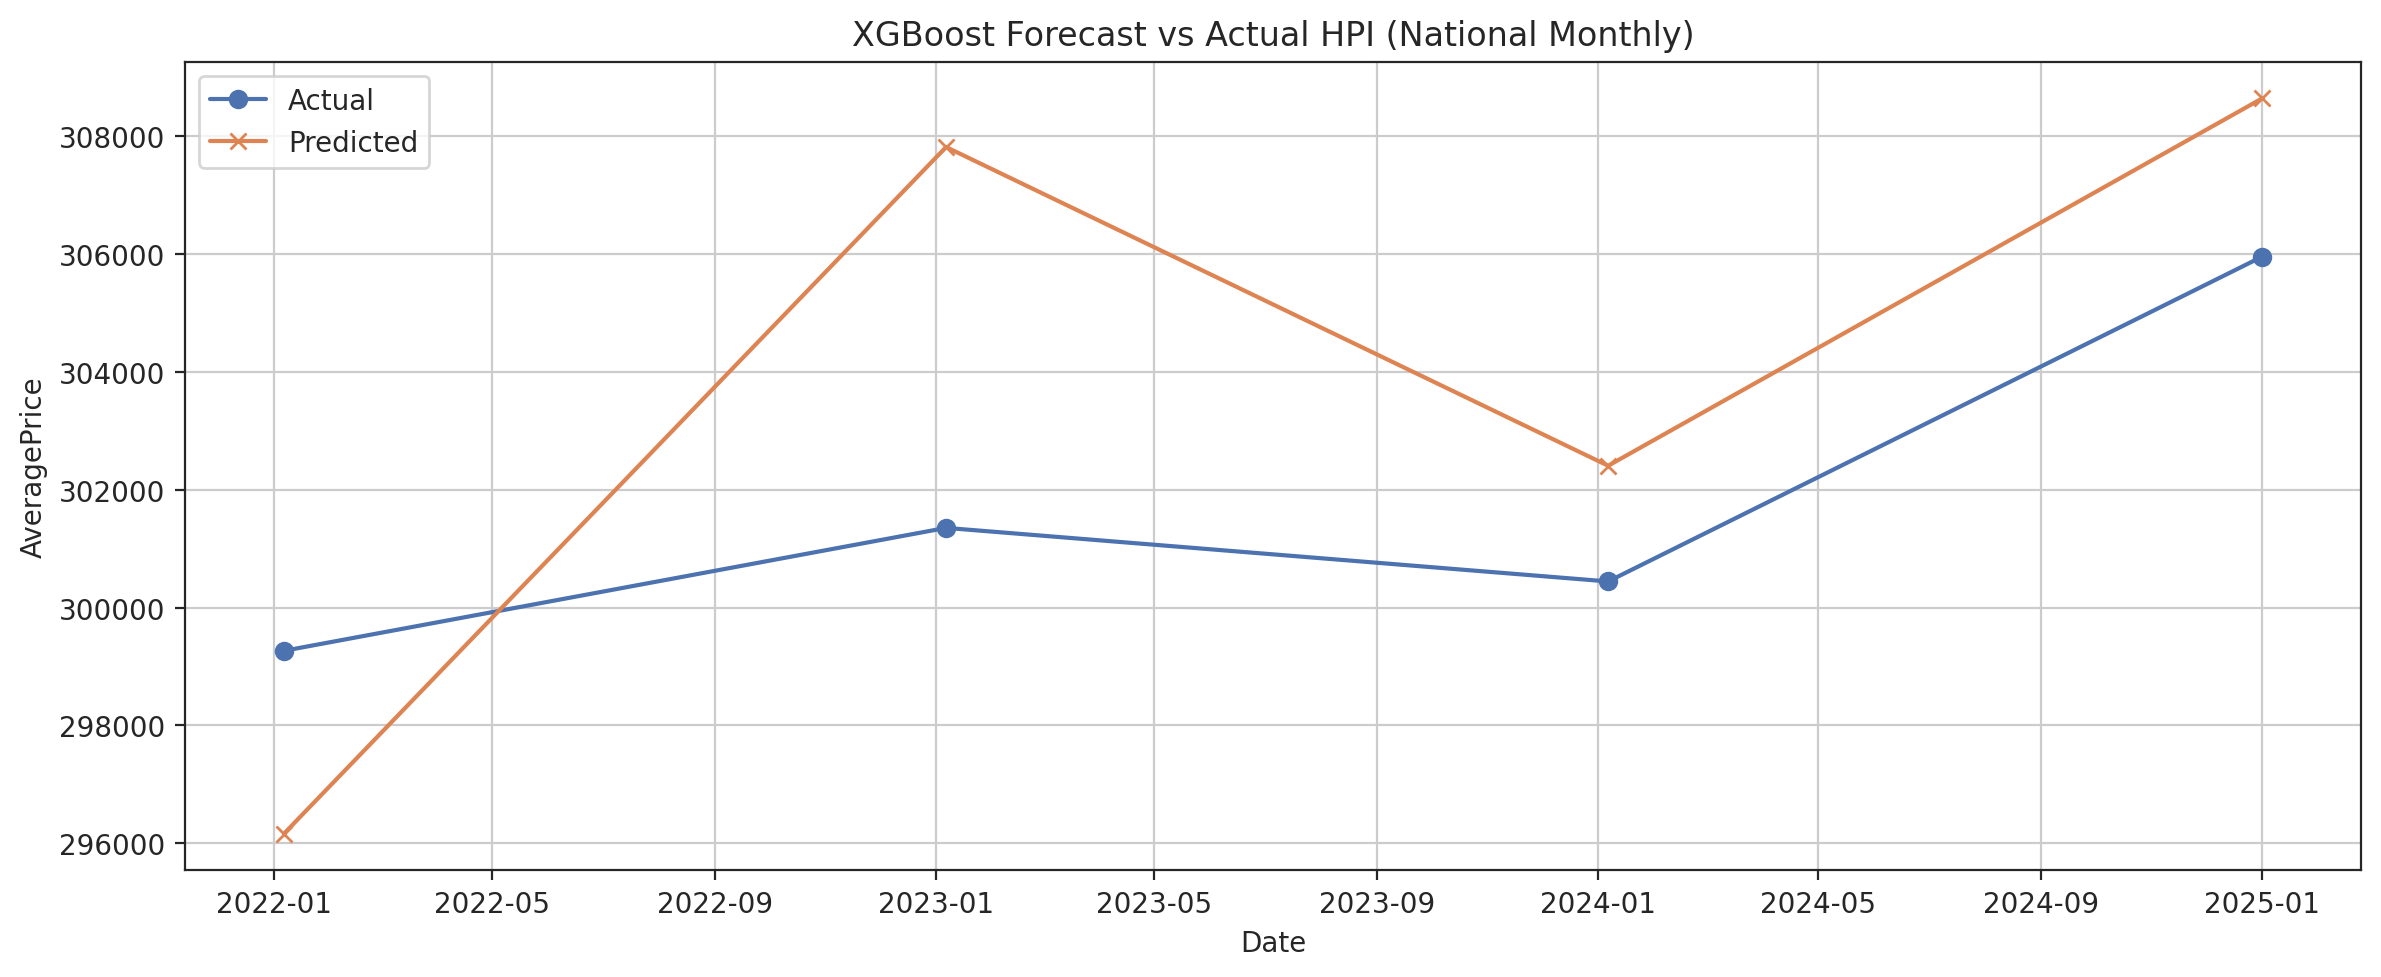

In [ ]:
out = test[["Date"]].copy()
out["Actual"] = y_test.values
out["Predicted"] = y_pred

# Average across all regions per month
monthly = out.groupby(out["Date"].dt.to_period("M"), as_index=False).mean()
monthly["Date"] = monthly["Date"].astype('datetime64[ns]')


import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(monthly["Date"], monthly["Actual"], "-o", label="Actual")
plt.plot(monthly["Date"], monthly["Predicted"], "-x", label="Predicted")
plt.xlabel("Date")
plt.ylabel("AveragePrice")
plt.title("XGBoost Forecast vs Actual HPI (National Monthly)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#LSTM model

Epoch 1/5
821/821 ━━━━━━━━━━━━━━━━━━━━ 45s 52ms/step - loss: 0.0012 - val_loss: 1.3349e-04
Epoch 2/5
821/821 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - loss: 2.0931e-04 - val_loss: 9.9221e-05
Epoch 3/5
821/821 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - loss: 1.6382e-04 - val_loss: 1.0664e-04
Epoch 4/5
821/821 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - loss: 1.5188e-04 - val_loss: 9.1254e-05
Epoch 5/5
821/821 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - loss: 1.4889e-04 - val_loss: 1.0252e-04
LSTM (window=36)
MAE:   24,071.00
RMSE:  58,892.19
R²:    0.8489
MAPE:  9.17%
sMAPE: 8.10%


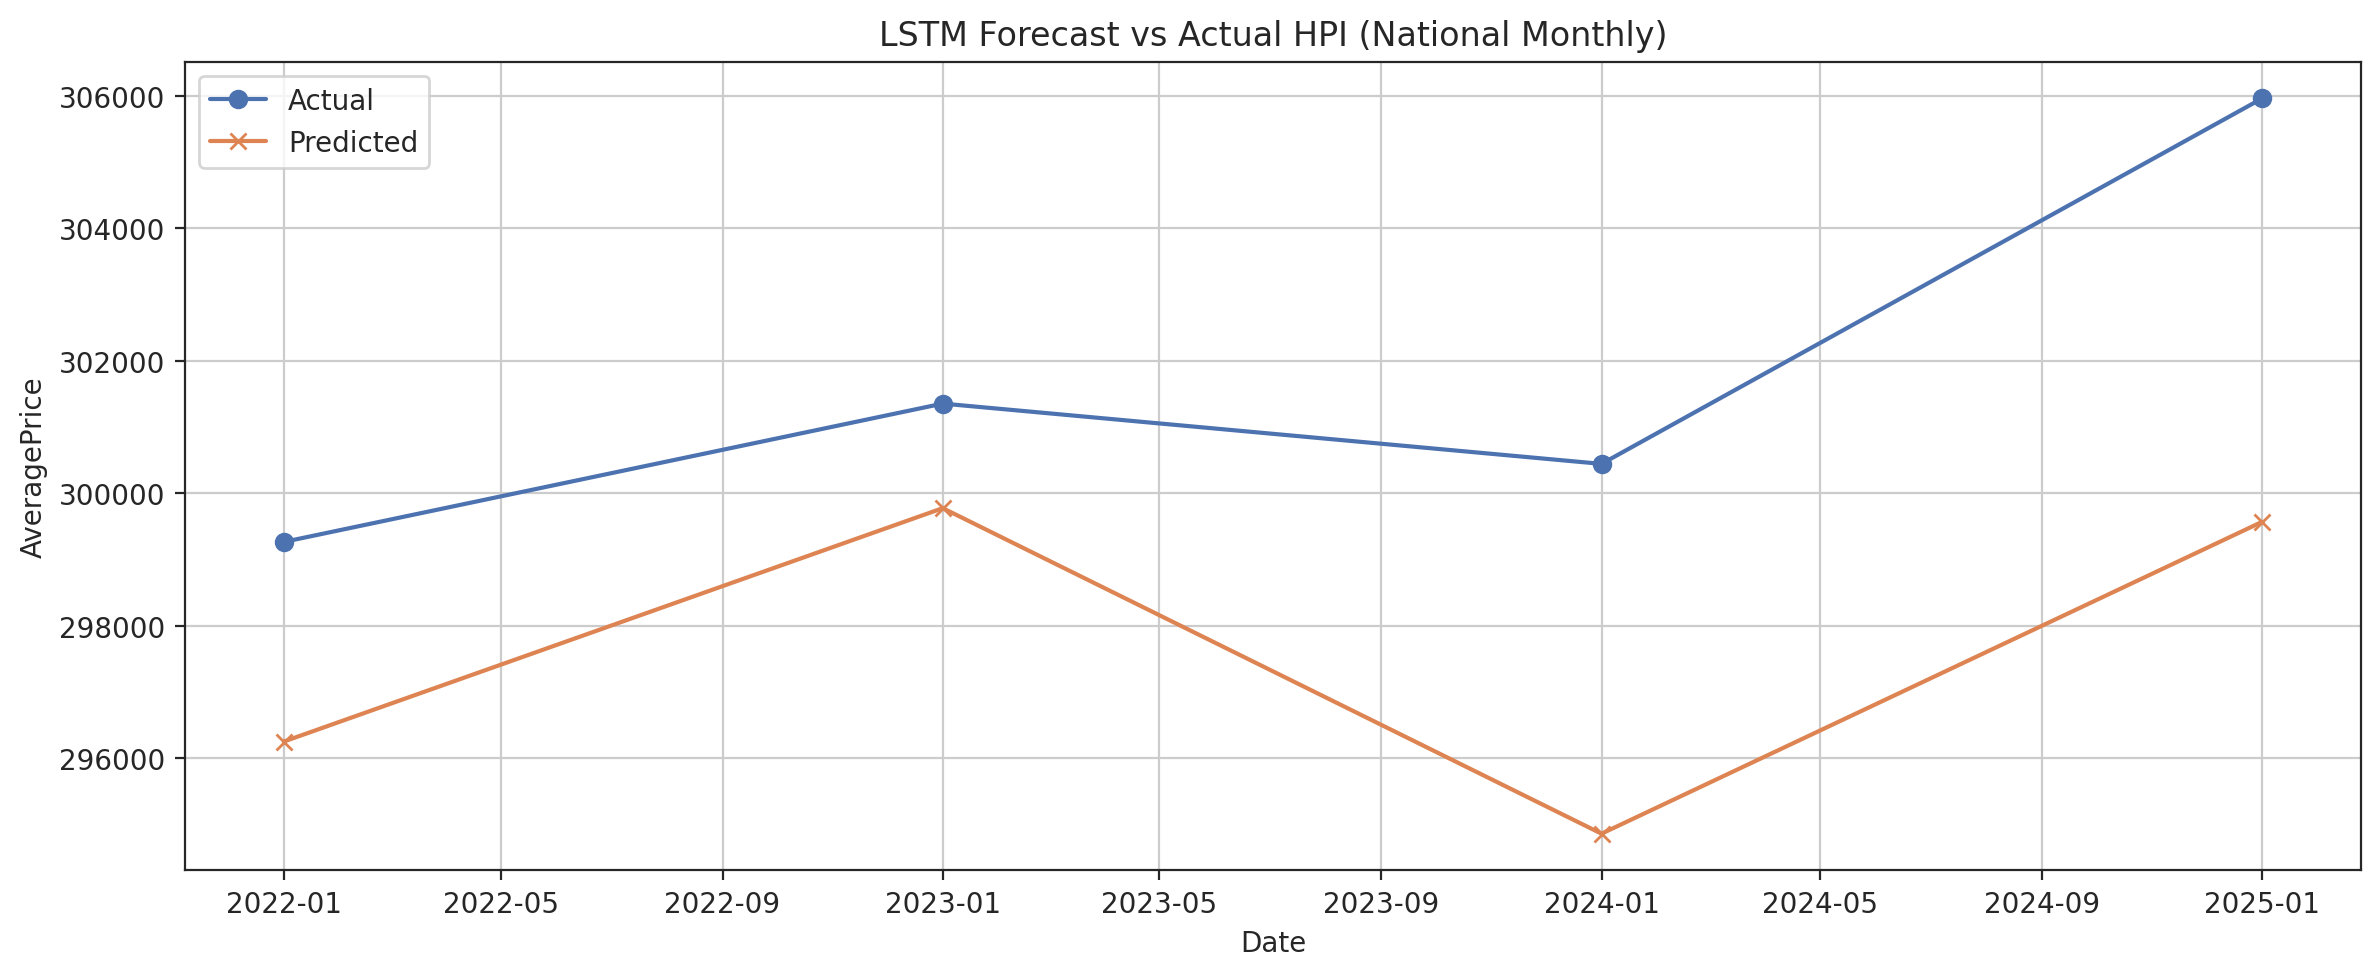

In [ ]:
# ===== Imports =====
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# --- extra metrics ---
def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true, float), np.asarray(y_pred, float)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def smape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true, float), np.asarray(y_pred, float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    mask = denom != 0
    return np.mean(np.abs(y_pred[mask] - y_true[mask]) / denom[mask]) * 100


# ===== 1) Select features (same as XGB) =====
feature_cols = [
    "RegionEncoded",
    "lag_1","lag_3","lag_6","lag_12","lag_24","lag_32",  # Corrected lags
    "roll_mean_3","roll_mean_6","roll_mean_12","roll_mean_32",
    "month","year"
]

# ===== 2) Scale target and features =====
scaler_y = MinMaxScaler()
scaler_X = MinMaxScaler()

y_train_scaled = scaler_y.fit_transform(train[["AveragePrice"]])
X_train_scaled = scaler_X.fit_transform(train[feature_cols])

y_test_scaled  = scaler_y.transform(test[["AveragePrice"]])
X_test_scaled  = scaler_X.transform(test[feature_cols])

# Recombine: target in col0 + features
train_scaled = np.hstack([y_train_scaled, X_train_scaled])
test_scaled  = np.hstack([y_test_scaled,  X_test_scaled])


# ===== 3) Build sequences =====
def make_sequences(arr, window):
    X, y = [], []
    for i in range(len(arr) - window):
        X.append(arr[i:i+window, :])   # shape (window, n_features)
        y.append(arr[i+window, 0])     # target = first col
    return np.array(X), np.array(y)

window = 36   # months to look back

X_train_seq, y_train_seq = make_sequences(train_scaled, window)

# Add last `window` train rows before test
test_in = np.vstack([train_scaled[-window:], test_scaled])
X_test_seq, y_test_seq  = make_sequences(test_in, window)

# Dates for plotting
test_dates = test["Date"].iloc[:len(y_test_seq)].values


# ===== 4) LSTM model =====
tf.keras.utils.set_random_seed(42)

model = Sequential([
    LSTM(64, input_shape=(window, X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    callbacks=[es],
    verbose=1
)


# ===== 5) Predict & inverse-transform =====
y_pred_scaled = model.predict(X_test_seq, verbose=0)

y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
y_true = scaler_y.inverse_transform(y_test_seq.reshape(-1,1)).ravel()


# ===== 6) Metrics =====
MAE  = mean_absolute_error(y_true, y_pred)
RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
R2   = r2_score(y_true, y_pred)
MAPE = mape(y_true, y_pred)
SMAPE = smape(y_true, y_pred)

print(f"LSTM (window={window})")
print(f"MAE:   {MAE:,.2f}")
print(f"RMSE:  {RMSE:,.2f}")
print(f"R²:    {R2:.4f}")
print(f"MAPE:  {MAPE:.2f}%")
print(f"sMAPE: {SMAPE:.2f}%")


# canonical month
out["Month"] = out["Date"].dt.to_period("M").dt.to_timestamp()

# national monthly averages
monthly = (out.groupby("Month")[["Actual","Predicted"]]
             .mean()
             .sort_index())

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(monthly.index, monthly["Actual"],    "-o", label="Actual")
plt.plot(monthly.index, monthly["Predicted"], "-x", label="Predicted")
plt.title("LSTM Forecast vs Actual HPI (National Monthly)")
plt.xlabel("Date"); plt.ylabel("AveragePrice")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
